In [3]:
import pandas as pd
import numpy as np

ModuleNotFoundError: No module named 'pandas'

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [ ]:
# Configurar el controlador de Chrome
driver = webdriver.Chrome()

# Abrir la página web
driver.get("https://systems.inei.gob.pe/SIRTOD/app/consulta")

# Esperar a que la página cargue completamente
wait = WebDriverWait(driver, 25)

# Paso 1: Esperar a que el loader desaparezca
wait.until(EC.invisibility_of_element_located((By.ID, "loader")))

# Paso 2: Hacer clic en el campo "Buscar indicador"
search_field = wait.until(EC.visibility_of_element_located((By.XPATH, '//*[@id="indicador-cajatexto"]')))
ActionChains(driver).move_to_element(search_field).perform()
search_field.click()

# Paso 3: Escribir "anemia" en el campo de búsqueda
search_field.send_keys("anemia")
search_field.send_keys(Keys.RETURN)

# Paso 4: Hacer clic en los checkboxes correspondientes
checkboxes = [
    '//*[@id="nodoh17779"]/img',
    '//*[@id="nodoh17780"]/img',
    '//*[@id="nodoh17781"]/img',
    '//*[@id="nodoh17782"]/img'
]

for checkbox_xpath in checkboxes:
    checkbox = wait.until(EC.element_to_be_clickable((By.XPATH, checkbox_xpath)))
    checkbox.click()

# Paso 5: Hacer clic en el botón de "Ejecutar"
ejecutar_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="ubigeo-ejecutar"]/button')))
ejecutar_button.click()

# Paso 6: Extraer la tabla que aparece después de aplicar los filtros
table = wait.until(EC.presence_of_element_located((By.CLASS_NAME, "pvtTable")))
rows = table.find_elements(By.TAG_NAME, "tr")

# Crear una lista para almacenar los datos
data = [[cell.text for cell in row.find_elements(By.TAG_NAME, "td")] for row in rows if row.find_elements(By.TAG_NAME, "td")]

# Convertir los datos en un DataFrame de pandas y eliminar la última columna vacía
df = pd.DataFrame(data).iloc[:, :-1]

# Definir los encabezados manualmente (para las 18 columnas restantes)
headers = [2000, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Verificar que el número de columnas coincida con los encabezados
if df.shape[1] == len(headers):
    df.columns = headers
else:
    print("El número de columnas en el DataFrame no coincide con la cantidad de encabezados proporcionados.")

# Agregar las dos nuevas columnas al lado izquierdo
df.insert(0, 'Departamento', '')
df.insert(1, 'Indicador Anemia %', '')

# Lista de departamentos
departamentos = [
    "AMAZONAS", "ÁNCASH", "APURÍMAC", "AREQUIPA", "AYACUCHO", "CAJAMARCA", 
    "CALLAO", "CUSCO", "HUANCAVELICA", "HUÁNUCO", "ICA", "JUNÍN", 
    "LA LIBERTAD", "LAMBAYEQUE", "LIMA", "LORETO", "MADRE DE DIOS", "MOQUEGUA", 
    "PASCO", "PIURA", "PUNO", "SAN MARTÍN", "TACNA", "TUMBES", 
    "UCAYALI", "LIMA METROPOLITANA 1/", "LIMA 2/"
]

# Asignar nombres de departamentos
row_idx = 0
for departamento in departamentos:
    if departamento == "LIMA METROPOLITANA 1/":
        # Excepción para "LIMA METROPOLITANA 1/"
        df.loc[row_idx:row_idx+2, 'Departamento'] = departamento
        row_idx += 3
    else:
        df.loc[row_idx:row_idx+3, 'Departamento'] = departamento
        row_idx += 4

# Llenar la columna 'Indicador Anemia %' con el patrón, omitiendo "Severa" para Lima Metropolitana
indicadores = ["Leve", "Moderada", "Severa", "Total"]
indicator_idx = 0

for idx in range(df.shape[0]):
    if df.at[idx, 'Departamento'] == "LIMA METROPOLITANA 1/" and indicator_idx == 2:
        # Saltar "Severa" para Lima Metropolitana
        indicator_idx += 1
    df.at[idx, 'Indicador Anemia %'] = indicadores[indicator_idx]
    indicator_idx = (indicator_idx + 1) % 4  # Reiniciar el patrón cada 4 indicadores

# Eliminar filas adicionales innecesarias
df.drop(index=df.index[[107, 108]], inplace=True)

# Reemplazar los NaN con el promedio de los valores numéricos en la misma fila
for col in df.columns[2:]:  
    df[col] = df[col].astype(str).replace('-', np.nan).str.replace(',', '.')
    df[col] = pd.to_numeric(df[col], errors='coerce') 

df.iloc[:, 2:] = df.iloc[:, 2:].apply(
    lambda row: row.fillna(row.mean()), axis=1
)

# (Opcional) Volver a formatear los números con comas como separador decimal
for col in df.columns[2:]:
    df[col] = df[col].apply(lambda x: f"{x:.1f}".replace('.', ','))

# Lista de las columnas de los años (como está en tu código)
year_columns = [2000, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Convertir los valores a float correctamente, reemplazando comas por puntos
for year in year_columns:
    df[year] = df[year].str.replace(',', '.').astype(float)

# Iterar sobre los departamentos
for depto in df['Departamento'].unique():
    # Filtrar las filas correspondientes a 'Leve', 'Moderada', 'Severa' para este departamento
    rows_to_sum = df[(df['Departamento'] == depto) & (df['Indicador Anemia %'].isin(['Leve', 'Moderada', 'Severa']))]

    # Filtrar la fila correspondiente a 'Total' para este departamento
    total_row_idx = df[(df['Departamento'] == depto) & (df['Indicador Anemia %'] == 'Total')].index

    if not rows_to_sum.empty and not total_row_idx.empty:
        # Iterar sobre las columnas de los años
        for year in year_columns:
            # Sumar los valores de los indicadores 'Leve', 'Moderada', 'Severa' para el año en cuestión
            total_value = rows_to_sum[year].sum(skipna=True)
            
            # Asignar la suma total al año correspondiente en la fila 'Total'
            df.at[total_row_idx[0], year] = total_value

# Ver el DataFrame resultante con los totales actualizados
print(df)
# Cerrar el navegador

              Departamento Indicador Anemia %  2000  2008  2009  2010  2011  \
0                 AMAZONAS               Leve  21.9  23.0  25.3  24.7  21.4   
1                 AMAZONAS           Moderada  20.0  13.7  12.4  14.6   8.2   
2                 AMAZONAS             Severa   0.5   0.4   1.0   1.0   0.5   
3                 AMAZONAS              Total  42.4  37.1  38.7  40.3  30.1   
4                   ÁNCASH               Leve  21.0  22.8  24.4  24.2  17.3   
..                     ...                ...   ...   ...   ...   ...   ...   
102  LIMA METROPOLITANA 1/              Total  24.2  24.2  24.2  24.2  24.2   
103                LIMA 2/               Leve  21.2  21.2  21.2  21.2  21.2   
104                LIMA 2/           Moderada   7.8   7.8   7.8   7.8   7.8   
105                LIMA 2/             Severa   0.2   0.2   0.2   0.2   0.2   
106                LIMA 2/              Total  29.2  29.2  29.2  29.2  29.2   

     2012  2013  2014  2015  2016  2017  2018  2019

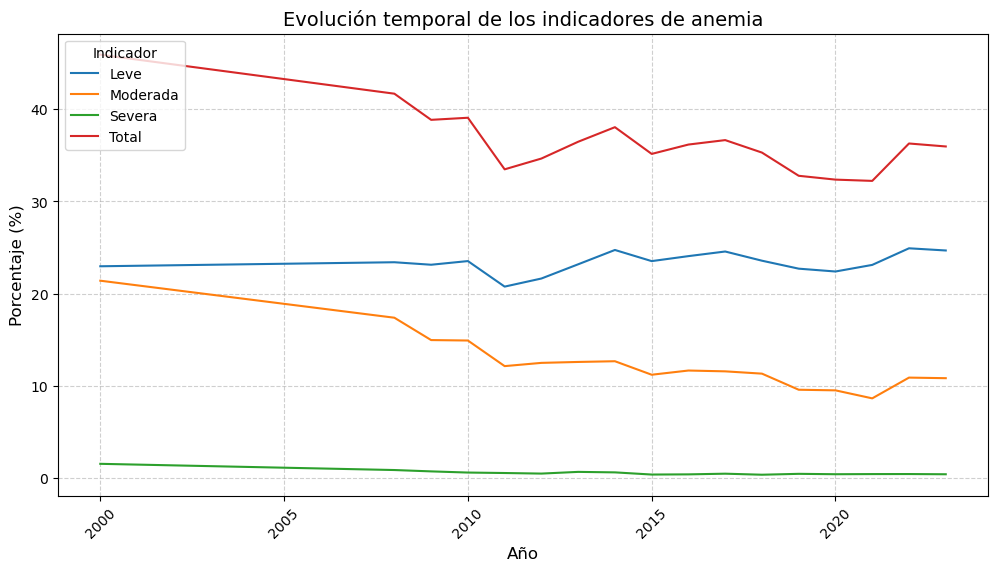

In [ ]:
import matplotlib.pyplot as plt

# Filtrar datos relevantes (sin columnas categóricas para el análisis numérico)
numeric_data = df.iloc[:, 2:]

# Calcular estimadores estadísticos
descriptive_stats = numeric_data.describe().T  # Transponer para claridad
descriptive_stats["Range"] = descriptive_stats["max"] - descriptive_stats["min"]
descriptive_stats

# Gráficos: Evolución temporal de los indicadores de anemia
plt.figure(figsize=(12, 6))
for indicator in df["Indicador Anemia %"].unique():
    subset = df[df["Indicador Anemia %"] == indicator]
    mean_values = subset.iloc[:, 2:].mean()
    plt.plot(mean_values.index, mean_values.values, label=indicator)

# Personalización del gráfico
plt.title("Evolución temporal de los indicadores de anemia", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Porcentaje (%)", fontsize=12)
plt.legend(title="Indicador", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.show()

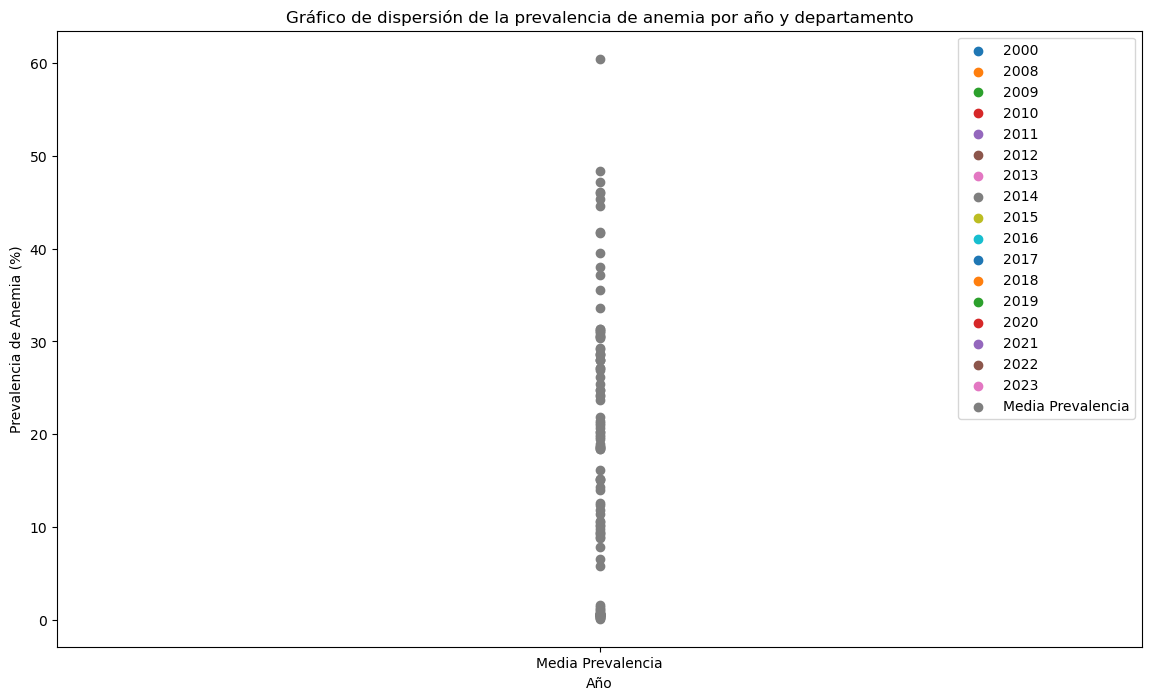

Departamentos con mayores tasas de prevalencia:
    Departamento  Media Prevalencia
83          PUNO          60.482353
31         CUSCO          48.329412
35  HUANCAVELICA          47.229412
99       UCAYALI          46.111765
63        LORETO          46.047059
Departamentos con menores tasas de prevalencia:
    Departamento  Media Prevalencia
58          LIMA           0.105882
26        CALLAO           0.200000
105      LIMA 2/           0.200000
78         PIURA           0.288235
86    SAN MARTÍN           0.305882
Departamentos que son outliers por año:
     2000   2008   2009  2010   2011  2012   2013  2014  2015  2016   2017  \
31  CUSCO  CUSCO  CUSCO   NaN  CUSCO   NaN  CUSCO   NaN   NaN   NaN  CUSCO   
83   PUNO   PUNO   PUNO  PUNO   PUNO  PUNO   PUNO  PUNO  PUNO  PUNO   PUNO   
91  TACNA    NaN    NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN    NaN   

    2018   2019   2020  2021  2022  2023  
31   NaN  CUSCO  CUSCO   NaN   NaN   NaN  
83  PUNO   PUNO   PUNO  PUNO  PUN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que los datos están en un dataframe llamado df
# df = pd.read_csv('datos_anemia.csv')

# Calcular la desviación estándar anual y detectar outliers
mean_anual = df.iloc[:, 2:].mean(axis=0)
std_anual = df.iloc[:, 2:].std(axis=0)

outliers = pd.DataFrame()
for year in df.columns[2:]:
    outliers[year] = df['Departamento'][np.abs(df[year] - mean_anual[year]) > 2 * std_anual[year]]

# Comparar departamentos con las mayores y menores tasas de prevalencia
df['Media Prevalencia'] = df.iloc[:, 2:].mean(axis=1)
mayores_tasas = df.nlargest(5, 'Media Prevalencia')
menores_tasas = df.nsmallest(5, 'Media Prevalencia')

# Crear gráficos de dispersión por años
plt.figure(figsize=(14, 8))
for year in df.columns[2:]:
    plt.scatter([year] * df.shape[0], df[year], label=year)

plt.xlabel('Año')
plt.ylabel('Prevalencia de Anemia (%)')
plt.title('Gráfico de dispersión de la prevalencia de anemia por año y departamento')
plt.legend()
plt.show()

# Resultados
print("Departamentos con mayores tasas de prevalencia:")
print(mayores_tasas[['Departamento', 'Media Prevalencia']])

print("Departamentos con menores tasas de prevalencia:")
print(menores_tasas[['Departamento', 'Media Prevalencia']])

print("Departamentos que son outliers por año:")
print(outliers)

# Departamentos con alta prevalencia en 2023 son consistentemente los más afectados en casos de Anemia

### Tendencias temporales para los departamentos con mayores proporciones en casos de Anemia en 2023

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrar solo las filas con 'Indicador Anemia %' == 'Total'
df_total = df[df['Indicador Anemia %'] == 'Total']

# Tendencias temporales para los departamentos con mayores proporciones en 2023
top_departamentos = df_total.nlargest(5, 2023)['Departamento']
plt.figure(figsize=(10, 6))
for depto in top_departamentos:
    data_depto = df_total[df_total['Departamento'] == depto]
    plt.plot(data_depto.columns[2:], data_depto.iloc[0, 2:], marker='o', label=depto)

plt.title('Tendencia de Proporciones de Anemia Total (Top 5 Departamentos)')
plt.xlabel('Año')
plt.ylabel('Proporción (%)')
plt.legend(title='Departamento')
plt.grid(True)
plt.show()

##### Interpretación:
- El gráfico muestra cómo ha cambiado la proporción de anemia en los 5 departamentos con mayor prevalencia en un año específico,
  en este caso el reciente año 2023 a lo largo del  tiempo.
- Se observa que el departamento 'Puno' parece tener consistentemente valores más altos de anemia en comparación con
  los otros departamentos, con una tendencia oscilante pero en general alta.
- El departamento de Ucayali muestra una caída drástica en algún punto después del año 2000 y luego una recuperación notable.

### Comparación en el año 2023 de los 5 departamentos con mayor proporción de Anemia

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Comparación en el año 2023 mostrando solo los 5 departamentos con mayor proporción
top_5_2023 = df_total.nlargest(5, 2023)
plt.figure(figsize=(8, 5))
plt.bar(top_5_2023['Departamento'], top_5_2023[2023], color=['skyblue', 'orange', 'green', 'purple', 'red'])
plt.title('Top 5 Departamentos con Mayor Proporción de Anemia en 2023')
plt.xlabel('Departamento')
plt.ylabel('Proporción (%)')
plt.show()

##### Interpretación:
- Puno tiene la proporción más alta de anemia total en 2023, alcanzando un valor de aproximadamente 60%. Esto lo posiciona
  como el departamento más afectado por la anemia en ese año.
- Los otros 4 departamentos (Ucayali, Loreto, Huancavelica y Madre de Dios) presentan proporciones relativamente similares,
  alrededor del rango de 40-50%. Esto podría indicar un comportamiento más homogéneo entre estos departamentos, en contraste con el valor
  significativamente alto en Puno.